***
*Project:* The Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Document 3</span> 

# Modern Helmholtz Machine

*Created:* April 13, 2025

The modified Helmholtz machine structure is given below:

<img src="Modern.jpg" style="width:800px">
<caption><center> **Figure 1**: Modern Helmholtz Machine. Blue neurons represent instantiation layers, where the neurons take binary values. Orange neurons indicate the inserted activations, where the neurons take value in real numbers in given range.    </center></caption>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of shape (n_mlp_max, n_smp). n_mlp_max is the maximum number of MLP layers. 
            n_smp is the number of sampled layers
    dev -- torch device

    Returns:
    Phi, Theta -- set of parameters (random initialization) for hierarchical layers. len(Phi) = n_smp-2. len(Theta) = n_smp-1.
    """
    Phi = {}
    Theta = {}
    n_smp = n_dz.shape[1]
    for i in range(n_smp-2):
        n_mlp = len(torch.where(n_dz[:,i] != 0)[0])
        Phi["Phi_" + str(i) + str(i+1)] = {}
        for j in range(n_mlp-1):
            Phi["Phi_" + str(i) + str(i+1)][j] = torch.rand(n_dz[j+1,i],n_dz[j,i],device=dev)
        Phi["Phi_" + str(i) + str(i+1)][n_mlp-1] = torch.rand(n_dz[0,i+1],n_dz[n_mlp-1,i],device=dev)
    for i in range(n_smp-1,0,-1):
        n_mlp = len(torch.where(n_dz[:,i-1] != 0)[0])
        Theta["Theta_" + str(i) + str(i-1)] = {}
        Theta["Theta_" + str(i) + str(i-1)][0] = torch.rand(n_dz[n_mlp-1,i-1],n_dz[0,i],device=dev)
        for j in range(n_mlp-1):
            Theta["Theta_" + str(i) + str(i-1)][j+1] = torch.rand(n_dz[n_mlp-j-2,i-1],n_dz[n_mlp-j-1,i-1],device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def layer_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    
    Returns:
    q -- probability of sample layer y, torch tensor of shape (n_y,batch_size)
    """
    n_mlp = len(param)
    q = x
    for i in range(n_mlp):
        q = one_step_forward(q,param[i])
    return q

In [6]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [7]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [8]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [9]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    
    Returns:
    param -- updated parameters from x to y.
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    Q -- the activations of each layer. Bernoulli probabilities. Python dictionary of length n_mlp, of keys 0,1,2,...
    """
    batch_size = x.shape[1]
    n_mlp = len(param)
    Q = {}    # activation/ probability
    q = x
    for i in range(n_mlp):
        Q[i] = one_step_forward(q,param[i])
        q = Q[i]
    u = Q[n_mlp-1] - y # (n_y,batch_size)
    loss = cross_entropy_loss(y,Q[n_mlp-1])
    for i in range(n_mlp-1,0,-1):
        dW = torch.matmul(u,torch.t(Q[i-1]))/batch_size
        dz = torch.matmul(torch.t(param[i]),u) # (n_z,batch_size)
        param[i] -= lr*dW
        u = dz * Q[i-1] * (1-Q[i-1])
    dW_x = torch.matmul(u,torch.t(x.type(torch.float)))/batch_size
    param[0] -= lr*dW_x
    return param, loss, Q

In [10]:
def wake_phase_fixed(Phi,fixed_sample,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    fixed_sample -- scheduled sampling at each hierchical layer. Python dictionary of length n_layer-1.
                    Each element is a torch tensor of shape (n_dz[0,i],batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated wake phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = fixed_sample['Layer_0'].shape[1]
    for i in range(n_layer-2):
        Phi["Phi_" + str(i) + str(i+1)], Loss[i+1], Q = \
        one_step_update(fixed_sample['Layer_'+str(i)],fixed_sample['Layer_'+str(i+1)],Phi["Phi_" + str(i) + str(i+1)],lr)
    return Phi, Loss

In [11]:
def sleep_phase_fixed(Theta,fixed_sample,lr,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    fixed_sample -- scheduled sampling at each hierchical layer. Python dictionary of length n_layer-1.
                    Each element is a torch tensor of shape (n_dz[0,i],batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = fixed_sample['Layer_0'].shape[1]
    fixed_sample['Layer_'+str(n_layer-1)] = torch.ones(1,batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)], Loss[i-1], Q = \
        one_step_update(fixed_sample['Layer_'+str(i)],fixed_sample['Layer_'+str(i-1)],Theta["Theta_" + str(i) + str(i-1)],lr)
    return Theta, Loss

In [12]:
def wake_sample_HM(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        input_x = sample(q,dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [13]:
def sleep_sample_HM(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        input_x = sample(q,dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample

In [14]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    H_YX -- conditional entropy from layer X to Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    return H_Y, H_YX

In [15]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    H_Y_wake = torch.zeros(n_layer-2)
    H_YX_wake = torch.zeros(n_layer-2)
    for i in range(n_layer-2):
        q = layer_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], H_YX_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample, H_Y_wake, H_YX_wake

In [16]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    H_Y_sleep = torch.zeros(n_layer-1)
    H_YX_sleep = torch.zeros(n_layer-1)
    for i in range(n_layer-1,0,-1):
        q = layer_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], H_YX_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample, H_Y_sleep, H_YX_sleep

In [17]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [18]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [19]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [20]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [21]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [22]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [23]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    
    # Compute output layer distribution
    q = layer_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, loss, Q = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, loss

In [24]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2], Q = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [25]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(layer_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

## Mutual Information Maximization
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

In [26]:
def MI_sample_batch(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1,keepdim=True) # (n_y,1)
    p_sample = (p_y < 0.5).long()
    output_y = sample(q,dev) # (n_y,batch_size)
    
    mask = ((q - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
    y_sample = mask * q_sample + (1-mask) * p_sample
    
    output_y = y_sample
#     output_y[:,int(batch_size/2)] = y_sample[:,int(batch_size/2)]
    
    return output_y

In [27]:
def MI_sample_batch_acc(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    output_y = sample(q,dev) # (n_y,batch_size)
    
    for i in range(batch_size):
        p_sample = (p_y < 0.5).long()
        mask = ((q[:,i] - 0.5).abs() - (p_y - 0.5).abs() > 0).long()
        y_sample = mask * q_sample[:,i] + (1-mask) * p_sample
        output_y[:,i] = y_sample
        p_y = (1-eps)*p_y + eps*y_sample
    
    return output_y

In [28]:
def MI_sample_batch_acc_comp(input_x,param,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    
    # minimum H(Y)
    p_y = q.mean(axis=1) # (n_y,)
    n_y = len(p_y)
    output_y = sample(q,dev) # (n_y,batch_size)
    
    for j in range(batch_size):
        q_yx_0 = q[0,j]
        p_y_0 = p_y[0]
        if (q_yx_0 - 0.5).abs() > (p_y_0 - 0.5).abs():
            output_y[0,j] = (q_yx_0 > 0.5).long()
        else:
            output_y[0,j] = (p_y_0 < 0.5).long()
        
        for i in range(1,n_y):
            q_yx_i = q[i,j]
            p_y_i = p_y[i]
            k = 1
            ind0 = torch.where(output_y[:i,j] == 0)[0]
            ind1 = torch.where(output_y[:i,j] == 1)[0]
            if len(ind0) != 0:
                ind_choice = torch.where((output_y[ind0,:]).sum(axis=0) == 0)[0]
                if len(ind_choice) > 1:
                    p_y_0 = q[i,ind_choice[ind_choice != j]].mean()
                    p_y_i = p_y_i + p_y_0
                    k += 1
            if len(ind1) != 0:
                ind_choice = torch.where((output_y[ind1,:]).sum(axis=0) == len(ind1))[0]
                if len(ind_choice) > 1:
                    p_y_1 = q[i,ind_choice[ind_choice != j]].mean()
                    p_y_i = p_y_i + p_y_1
                    k += 1
            p_y_i = p_y_i/k

            if (q_yx_i - 0.5).abs() > (p_y_i - 0.5).abs():
                output_y[i,j] = (q_yx_i > 0.5).long()
            else:
                output_y[i,j] = (p_y_i < 0.5).long()

        p_y = (1-eps)*p_y + eps*output_y[:,j]

    return output_y

In [29]:
def MI_train_batch(input_x,param_xy,param_yx,lr,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    output_y = MI_sample_batch_acc(input_x,param_xy,eps,dev)
    
    # train the opposite phase from x to y
    param_yx, loss, Q = one_step_update(output_y,input_x,param_yx,lr)

    return output_y, param_yx, loss

In [30]:
def wake_phase_MI_batch(Phi,Theta,data,lr,Epsilon,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,Epsilon[i],dev)
        input_x = output_y
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2], Q = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [31]:
def sleep_phase_MI_batch(Phi,Theta,gen_batch_size,lr,Epsilon_s,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    num -- number of random samples selected for training
    lr -- learning rate
    Epsilon_s -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(layer_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        MI_train_batch(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,Epsilon_s[i-1],dev)
        input_x = output_y
    return Phi, Loss

In [32]:
def MI_deterministic(input_x,param,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    output_y = q_sample
    n_y = q.shape[0]
    
    for i in range(n_y):
        q0 = q[i,:] # (batch_size,)
        values,indices = (q0-0.5).abs().sort()
        Sum = output_y[i,:].sum()
        for j in range(batch_size):
            p_y = Sum/batch_size
            p_sample = (p_y < 0.5).long()
            if values[j] < (p_y - 0.5).abs() and output_y[i,indices[j]] != p_sample:
                output_y[i,indices[j]] = p_sample
                Sum = Sum + 2*p_sample-1
            elif values[j] > (p_y - 0.5).abs():
                break
        print('Neuron',str(i),',  batch',str(j))
    return output_y

In [33]:
def MI_sample_precise(input_x,param,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    """
    # H(Y|x)
    batch_size = input_x.shape[1]
    q = one_step_forward(input_x,param) # (n_y,batch_size)
    q_sample = (q > 0.5).long() # (n_y,batch_size)
    output_y = q_sample
    n_y = q.shape[0]
    p_y = output_y.float().mean(axis=1)
    
    for i in range(n_y):
        q_i = q[i,:] # (batch_size,)
        py_i = p_y[i] # number
        if py_i < 0.5:
            indices = torch.where((q_i > py_i) & (q_i < 0.5))[0]
            p_sample = 1
        else:
            indices = torch.where((q_i < py_i) & (q_i > 0.5))[0]
            p_sample = 0
            
        length = len(indices)
        if len(indices) > 0:
            val,ind = (q_i[indices] - 0.5).abs().sort()
            p_y_change = (py_i - 0.5).abs() - torch.arange(length,device=dev)/batch_size
            index = indices[ind[torch.where((val - p_y_change)<0)[0]]]
            output_y[i,index] = p_sample
    return output_y

In [46]:
def wake_sample_deterministic(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        print('Layer',str(i),':')
        input_x = MI_sample_precise(input_x,Phi["Phi_" + str(i) + str(i+1)],dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

## Model

In [35]:
dev = torch.device('cuda')

In [140]:
structure = np.array([[784,686,588,490,392,294,196,98,49,25,1],
                      [735,637,539,441,343,245,147,73,37,12,0]])
n_dz = torch.tensor(structure)
n_dz

tensor([[784, 686, 588, 490, 392, 294, 196,  98,  49,  25,   1],
        [735, 637, 539, 441, 343, 245, 147,  73,  37,  12,   0]],
       dtype=torch.int32)

In [71]:
structure = np.array([[784,686,637,588,539,490,392,294,196,98,49,25,1],
                      [735,661,612,563,514,441,343,245,147,73,37,12,0],]) # 14-1
n_dz = torch.tensor(structure)
n_dz

tensor([[784, 686, 637, 588, 539, 490, 392, 294, 196,  98,  49,  25,   1],
        [735, 661, 612, 563, 514, 441, 343, 245, 147,  73,  37,  12,   0]],
       dtype=torch.int32)

In [59]:
structure = np.array([[784,714,644,574,504,434,364,294,224,154,84,42,1],
                      [749,679,609,539,469,399,329,259,189,119,63,21,0],])
n_dz = torch.tensor(structure)
n_dz

tensor([[784, 714, 644, 574, 504, 434, 364, 294, 224, 154,  84,  42,   1],
        [749, 679, 609, 539, 469, 399, 329, 259, 189, 119,  63,  21,   0]],
       dtype=torch.int32)

In [56]:
structure = np.array([[784,735,686,637,588,539,490,441,392,343,294,245,196,147,98,49,25,10,1],
                      [650,710,662,612,564,515,465,416,368,318,270,220,172,122,74,37,17,5,0],
                      [500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                      [650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
n_dz = torch.tensor(structure)
n_dz

tensor([[784, 735, 686, 637, 588, 539, 490, 441, 392, 343, 294, 245, 196, 147,
          98,  49,  25,  10,   1],
        [650, 710, 662, 612, 564, 515, 465, 416, 368, 318, 270, 220, 172, 122,
          74,  37,  17,   5,   0],
        [500,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [350,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [200,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [350,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [500,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0],
        [650,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0]], dtype=torch.int32)

In [37]:
n_mlp_max = n_dz.shape[0]
n_layer = n_dz.shape[1]
n_d = n_dz[0,0]

In [38]:
image_binary = torch.load('D:\deep music\MNIST\MNIST\MNIST_binary.pt',dev,weights_only=True)
image_binary.shape

torch.Size([60000, 28, 28])

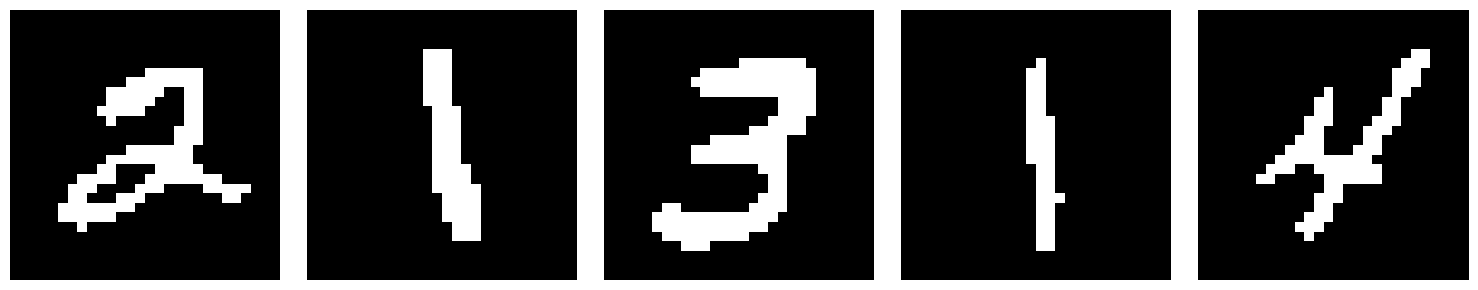

In [39]:
# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image_binary[i+5,:,:].to('cpu').numpy(), cmap='gray')
#         plt.imshow(image.squeeze()[i+300,:,:].to('cpu').numpy(), cmap='gray')
#         plt.title(f"Label: {label[i+5].item()}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [40]:
data = image_binary.reshape(-1,784).t()
data.shape

torch.Size([784, 60000])

In [41]:
Phi,Theta = para_init(n_dz,dev)

In [41]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Phi_Loss_Layer_5',
 'Phi_Loss_Layer_6',
 'Phi_Loss_Layer_7',
 'Phi_Loss_Layer_8',
 'Phi_Loss_Layer_9',
 'Phi_Loss_Layer_10',
 'Phi_Loss_Layer_11',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Theta_Loss_Layer_5',
 'Theta_Loss_Layer_6',
 'Theta_Loss_Layer_7',
 'Theta_Loss_Layer_8',
 'Theta_Loss_Layer_9',
 'Theta_Loss_Layer_10',
 'Theta_Loss_Layer_11',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_H_Layer_5',
 'Recog_H_Layer_6',
 'Recog_H_Layer_7',
 'Recog_H_Layer_8',
 'Recog_H_Layer_9',
 'Recog_H_Layer_10',
 'Recog_H_Layer_11',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Recog_I_Layer_4',
 'Recog_I_Layer_5',
 'Recog_I_Layer_6',
 'Recog_I_Layer_7',
 'Recog_I_Layer_8',
 'Recog_I_Layer_9',
 'Recog_I_Layer_10',
 'Recog_I_Layer_11',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_L

In [42]:
len(col_list)

68

## Scheduling

In [54]:
Analytic_MNIST_new_batch5000 = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_new_batch5000.csv', sep=",")
Analytic_MNIST_new_batch5000

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693148,0.693147,0.693147,...,17.328680,0.056961,0.000275,0.000153,0.000122,0.000061,0.000031,0.000000,0.000008,0.000000
1,0.433051,0.088980,0.129885,0.336500,0.661391,0.692569,0.693086,0.693137,0.693145,0.733592,...,17.328670,0.219311,0.007507,0.012344,0.070545,0.209625,0.043915,0.001343,0.000191,0.000042
2,0.416129,0.090037,0.163008,0.167657,0.622258,0.691826,0.693029,0.693119,0.693150,0.712715,...,17.328642,0.523369,0.007935,0.015984,0.044891,0.178558,0.091339,0.002991,0.000351,0.000061
3,0.424641,0.095837,0.186577,0.132144,0.620057,0.691436,0.692971,0.693108,0.693141,0.748648,...,17.328629,0.845078,0.008453,0.021046,0.040306,0.158844,0.091949,0.003937,0.000519,0.000095
4,0.428273,0.104279,0.173114,0.159998,0.625164,0.691247,0.692910,0.693106,0.693146,0.698957,...,17.328625,1.427055,0.009430,0.022728,0.046585,0.207657,0.087494,0.004440,0.000664,0.000122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,0.201977,0.323960,0.096444,0.086174,0.109483,0.135288,0.264563,0.245311,0.484456,0.057753,...,15.876793,148.746170,81.011887,93.279831,41.855736,32.884045,27.118580,21.976484,17.299055,10.266393
6690,0.201951,0.323857,0.096710,0.086140,0.109729,0.135156,0.264079,0.245531,0.484113,0.057633,...,15.870464,149.146133,81.232452,93.447815,41.949829,32.897633,27.120609,21.950743,17.301462,10.268412
6691,0.201760,0.324678,0.096383,0.086531,0.109106,0.135551,0.263535,0.246534,0.484180,0.057722,...,15.867100,149.286041,81.162369,93.447617,41.881840,32.906769,27.129906,21.987841,17.315533,10.255956
6692,0.201936,0.324142,0.096427,0.086259,0.109229,0.134969,0.264203,0.245119,0.484573,0.057643,...,15.874424,149.528336,81.212494,93.511230,41.925385,32.892567,27.114422,21.954800,17.317669,10.266495


In [102]:
Analytic_MNIST_new_batch5000_l1 = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_new_batch5000_l1_random.csv', sep=",")
Analytic_MNIST_new_batch5000_l1

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,9.558345,10.169810,9.090590,8.906387,8.833921,8.686323,8.069989,6.907906,4.777973,9.623112,...,15.295483,-0.000044,-0.000025,-0.000008,0.000002,0.000002,0.000027,0.000046,0.024082,0.007315
1,3.629129,4.440176,1.437043,1.023701,0.828956,0.652730,0.355488,0.297463,0.486563,2.621040,...,15.828798,-0.000027,-0.000069,-0.000065,-0.000010,3.450359,25.092987,16.947592,16.027895,9.972886
2,3.618255,4.411416,1.438795,1.021681,0.758461,0.349905,0.301407,0.269058,0.484462,2.625973,...,15.827031,-0.000011,-0.000025,-0.000019,20.175531,24.624422,28.662975,20.485199,16.514860,10.105296
3,3.610989,4.414405,1.453876,1.026857,0.573571,0.333507,0.287285,0.257698,0.484051,2.621571,...,15.825633,-0.000053,-0.000019,-0.000008,29.166340,31.549600,25.782652,20.315603,16.834938,10.145937
4,3.609618,4.432313,1.436259,1.036238,0.480320,0.262423,0.285037,0.253789,0.484142,2.630916,...,15.829835,-0.000042,-0.000042,-0.000038,30.309465,35.337982,28.000877,20.553560,17.084002,10.194837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1.783457,4.437513,1.449875,0.580226,0.128184,0.134780,0.263640,0.245474,0.483493,2.631906,...,15.827120,-0.000027,0.000002,132.892840,44.027782,33.372543,27.524666,22.241037,17.556429,10.250548
142,1.755560,4.437985,1.435508,0.578341,0.127031,0.135282,0.263247,0.245545,0.483008,2.632320,...,15.825682,-0.000004,-0.000044,127.825740,45.100628,33.432970,27.305492,22.112715,17.465765,10.252445
143,1.736384,4.437964,1.454785,0.590484,0.127592,0.134912,0.264319,0.245855,0.483787,2.638741,...,15.827483,0.000004,-0.000025,123.066950,44.448586,33.373795,27.356220,21.970690,17.434286,10.236175
144,1.750272,4.430208,1.424584,0.576949,0.126294,0.134696,0.263433,0.245814,0.482959,2.620090,...,15.821604,-0.000027,-0.000055,127.962660,44.673010,33.239620,27.292759,21.790789,17.347034,10.291680


In [93]:
Analytic_MNIST_14_batch5000_l1 = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_14_batch5000_l1.csv', sep=",")
Analytic_MNIST_14_batch5000_l1

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Phi_Loss_Layer_10,...,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9,Gen_I_Layer_10,Gen_I_Layer_11
0,16.116861,17.177366,18.452137,18.802591,18.493810,17.276377,18.360447,15.013818,13.369984,11.013298,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000041
1,0.318397,0.243484,0.129139,0.125893,0.153491,0.288972,0.161247,0.505371,0.605066,0.669180,...,0.000061,0.000015,0.000000,-0.000008,-0.000015,0.000122,0.000004,0.000031,0.205078,0.070503
2,0.318396,0.243484,0.129136,0.125303,0.153435,0.287895,0.159785,0.505303,0.600421,0.654705,...,-0.000092,0.000046,0.000000,-0.000011,0.000015,0.000122,-0.000008,0.278023,3.699001,1.467547
3,0.318396,0.243484,0.129133,0.124477,0.153371,0.287883,0.159784,0.505214,0.600420,0.555629,...,0.000000,0.000015,-0.000008,-0.000015,0.000008,0.000107,-0.000015,3.442131,9.127113,5.715855
4,0.318396,0.243484,0.129130,0.123269,0.152922,0.287871,0.159783,0.504966,0.600420,0.433114,...,0.000000,-0.000031,-0.000008,0.000008,0.000000,0.000145,-0.000015,9.186249,13.125786,8.893847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,0.317468,0.319302,0.346186,0.383261,0.434626,0.510432,0.576753,0.641793,0.668389,0.682123,...,0.000023,-0.000008,0.000015,0.000046,-0.000031,0.000031,0.000000,0.001907,0.003105,0.006336
450,0.302405,0.325676,0.350969,0.374825,0.421335,0.503836,0.583398,0.630119,0.666792,0.684092,...,-0.000015,-0.000061,0.000015,-0.000046,0.000031,-0.000015,0.000076,0.001610,0.003197,0.006710
451,0.301696,0.333370,0.346868,0.374521,0.422277,0.509557,0.572956,0.640622,0.670186,0.684709,...,0.000008,0.000015,-0.000031,-0.000031,0.000031,-0.000015,0.000031,0.001854,0.002243,0.006550
452,0.304926,0.329033,0.349818,0.380102,0.425875,0.503390,0.579743,0.640697,0.675426,0.684789,...,-0.000038,0.000015,0.000031,-0.000031,0.000000,0.000015,-0.000015,0.001091,0.001717,0.005802


In [58]:
Analytic_MNIST_11_19_wsMI_l1 = pd.read_csv('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Analytic_MNIST_11_19_wsMI_l1.csv', sep=",")
Analytic_MNIST_11_19_wsMI_l1

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Phi_Loss_Layer_10,...,Gen_I_Layer_8,Gen_I_Layer_9,Gen_I_Layer_10,Gen_I_Layer_11,Gen_I_Layer_12,Gen_I_Layer_13,Gen_I_Layer_14,Gen_I_Layer_15,Gen_I_Layer_16,Gen_I_Layer_17
0,14.109923,13.293452,11.528473,11.736550,11.024567,10.014987,9.598950,9.570092,8.427991,8.350411,...,-0.000012,-0.000335,-0.000275,-0.000045,-0.00007,0.000013,0.000031,-0.000008,-0.000003,0.005877
1,0.562969,0.506729,0.630852,0.619169,0.670916,0.636563,0.652747,0.660234,0.557144,0.636611,...,0.000000,0.000031,0.000031,-0.000031,0.00000,0.000000,0.000000,9.137486,6.213987,1.620234
2,0.562969,0.506729,0.630843,0.619169,0.670916,0.636560,0.652747,0.660224,0.557095,0.636443,...,0.000000,-0.000031,-0.000107,-0.000015,0.00000,0.000000,0.000000,28.722675,14.072039,3.341803
3,0.562853,0.506729,0.630841,0.619169,0.670916,0.636530,0.652747,0.660221,0.557079,0.636336,...,0.000000,-0.000092,-0.000061,-0.000046,0.00000,0.000000,0.000000,37.178032,17.506556,4.139216
4,0.562800,0.506729,0.630816,0.619169,0.670916,0.636440,0.652747,0.660220,0.557044,0.636249,...,0.000000,-0.000031,-0.000031,-0.000061,0.00000,0.000000,0.000000,41.637390,19.141144,4.585299
5,0.562800,0.506729,0.630795,0.619169,0.670916,0.636378,0.652747,0.660219,0.557008,0.636172,...,0.000000,-0.000061,-0.000076,0.000076,0.00000,0.000000,0.000000,44.038320,20.681942,4.970408
6,0.562800,0.506729,0.630777,0.619169,0.670916,0.636323,0.652747,0.660219,0.556984,0.636139,...,0.000000,0.000031,-0.000107,0.000000,0.00000,0.000000,0.000000,46.277893,21.716120,5.290250
7,0.562800,0.506729,0.630762,0.619169,0.670916,0.636282,0.652747,0.660219,0.556956,0.636104,...,0.000000,0.000061,-0.000107,-0.000061,0.00000,0.000000,0.000000,48.094560,22.493141,5.552577
8,0.562800,0.506729,0.630758,0.619169,0.670916,0.636272,0.652747,0.660218,0.556941,0.636084,...,0.000000,0.000061,-0.000046,-0.000092,0.00000,0.000000,0.000000,49.557060,23.041487,5.787356
9,0.562800,0.506729,0.630757,0.619169,0.670916,0.636265,0.652747,0.660218,0.556919,0.636067,...,0.000000,-0.000061,-0.000015,-0.000015,0.00000,0.000000,0.000000,50.535410,23.544077,6.081531


In [43]:
para = torch.load('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Parameters_MNIST_11_19_MI', dev,weights_only=True)
Phi_HM = para['Phi']
Theta_HM = para['Theta']

In [114]:
Phi,Theta = para_init(n_dz,dev)

In [59]:
para = torch.load('D:\Jupyter Notebook Files\Helmholtz Machine\Parameters_MNIST\Parameters_MNIST_11_19_wsMI_l1', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [49]:
# Schedule = torch.load('D:\Jupyter Notebook Files\Helmholtz Machine\Permanent\Schedule_MNIST_11_19_wsMI',dev,weights_only=True)

In [72]:
# scheduled_sample = wake_sample_deterministic(Phi_HM,data[:,:5000],dev)

In [106]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 20))
for i in range(n_layer-1):
    smp = schedule_sample['Layer_'+str(i)]
    dist = smp.float().mean(axis=1)
    
    ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i]),dist.to('cpu').numpy(), label = 'Layer_'+str(i))
    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[0,i].item())+" Neurons)",fontsize=20)
plt.tight_layout(pad=1)    
plt.show()

In [50]:
lr = 0.01
epoch = 10000
batch_size = 5000
gen_batch_size = 10000
n_data = data.shape[1]
batch_num = int(n_data/batch_size)
batch_num

12

In [57]:
Phi,Theta = para_init(n_dz,dev)

In [47]:
schedule_sample = wake_sample_deterministic(Phi_HM,data[:,:5000],dev)

Layer 0 :


In [48]:
schedule_sample['Layer_1']

tensor([[1, 1, 0,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 1],
        ...,
        [1, 0, 0,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 0, 1, 0],
        [0, 1, 0,  ..., 1, 1, 0]], device='cuda:0')

In [49]:
decimalize(schedule_sample['Layer_1'][:50,:],dev).unique().shape

torch.Size([4965])

In [58]:
epoch = 10000
for e in range(epoch):
    Phi["Phi_01"], Loss_wake,_ = one_step_update(schedule_sample['Layer_0'],schedule_sample['Layer_1'],Phi["Phi_01"],lr)
    Theta["Theta_10"], Loss_sleep,_ = one_step_update(schedule_sample['Layer_1'],schedule_sample['Layer_0'],Theta["Theta_10"],lr)
    if e%100 == 0:
        print('Loss_wake:',Loss_wake.item(),'    Loss_sleep:',Loss_sleep.item())

Loss_wake: 14.011543273925781     Loss_sleep: 17.365846633911133
Loss_wake: 0.6745191216468811     Loss_sleep: 0.41525453329086304
Loss_wake: 0.5875757336616516     Loss_sleep: 0.2626712918281555
Loss_wake: 0.5875757336616516     Loss_sleep: 0.262569397687912
Loss_wake: 0.5875757336616516     Loss_sleep: 0.26252785325050354
Loss_wake: 0.5875757336616516     Loss_sleep: 0.2625056505203247
Loss_wake: 0.5855768918991089     Loss_sleep: 0.26249194145202637
Loss_wake: 0.5855768918991089     Loss_sleep: 0.2624826431274414
Loss_wake: 0.5855768918991089     Loss_sleep: 0.2624759078025818
Loss_wake: 0.5855768918991089     Loss_sleep: 0.26247087121009827
Loss_wake: 0.5855768918991089     Loss_sleep: 0.2624669373035431
Loss_wake: 0.5855768918991089     Loss_sleep: 0.26246377825737
Loss_wake: 0.5855768918991089     Loss_sleep: 0.26246118545532227
Loss_wake: 0.5855768918991089     Loss_sleep: 0.26245900988578796
Loss_wake: 0.5855768918991089     Loss_sleep: 0.2624571919441223
Loss_wake: 0.585576891

KeyboardInterrupt: 

In [91]:
# Schedule = {}
# Schedule[0] = scheduled_sample

In [113]:
# for i in range(1,batch_num):
#     print('Sample group',str(i),':')
#     Schedule[i] = wake_sample_deterministic(Phi_HM,data[:,i*batch_size:(i+1)*batch_size],dev)

In [114]:
# torch.save(Schedule,'D:\Jupyter Notebook Files\Helmholtz Machine\Permanent\Schedule_MNIST_11\Schedule_MNIST_11')

In [49]:
# Schedule = torch.load('D:\Jupyter Notebook Files\Helmholtz Machine\Permanent\Schedule_MNIST_11_19_wsMI',dev,weights_only=True)

In [127]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    for i in range(batch_num):
        Phi, Loss_wake = wake_phase_fixed(Phi,Schedule[i],lr,dev)
        Theta, Loss_sleep = sleep_phase_fixed(Theta,Schedule[i],lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    if e%100 == 0:
        print('Loss_wake:',Loss_W/batch_num,'    Loss_sleep:',Loss_S/batch_num)
        stat = []
        stat = stat + list((Loss_wake[1:]/batch_num).to('cpu').numpy())
        stat = stat + list((Loss_sleep/batch_num).to('cpu').numpy())

        Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data[:,:10000],dev)
        Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
        Analytic_MNIST_new_batch5000_l1.loc[len(Analytic_MNIST_new_batch5000_l1)] = stat

In [1205]:
epoch = 10000
Epsilon = torch.ones(n_layer-2)*lr
Epsilon_s = torch.ones(n_layer-2)*lr
# Epsilon = initialize_MI(data,Phi,lr,dev)
# Epsilon_s = initialize_MI_sleep(Theta,batch_size,lr,dev)

In [1206]:
for e in range(epoch):
#     if e%10 == 0:
#         index = np.random.permutation(n_data)
#         data_permute = data[:,index]
#         Theta, Loss_sleep = wake_phase_MI_batch(Phi,Theta,data_permute,lr,Epsilon,dev)
#         Phi, Loss_wake = sleep_phase_MI_batch(Phi,Theta,batch_size,lr,Epsilon_s,dev)
#     else:
    Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        
    if e%1000 == 0:
        print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
#         stat = []
#         stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
#         stat = stat + list((Loss_sleep).to('cpu').numpy())

#         Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data.repeat(1,100),dev)
#         Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

#         gen_data = Gen_sample["Layer_0"]
#         gen_dcm = decimalize(gen_data,dev)
#         values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
#         gen_dist = torch.zeros(2**n_d,device=dev)
#         gen_dist[values_g]=counts_g/gen_batch_size

#         stat.append(KL_divergence(gen_dist,data_dist).item())
#         stat.append(KL_divergence(data_dist,gen_dist).item())

# #         k = 0
# #         for i in range(gen_batch_size):
# #             if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
# #                 k += 1
# #         stat.append(k/gen_batch_size)

#         stat = stat + list(H_Y_wake.to('cpu').numpy()) + list((H_Y_wake - H_YX_wake).to('cpu').numpy()) \
#                 + list(H_Y_sleep.to('cpu').numpy()) + list((H_Y_sleep - H_YX_sleep)[:-1].to('cpu').numpy())
#         Analytic_MHM_layer1.loc[len(Analytic_MHM_layer1)] = stat

Loss_wake: tensor([0.0000, 0.1441, 0.3172, 0.2817])     Loss_sleep: tensor([0.2885, 0.3587, 0.4677, 0.4513])
Loss_wake: tensor([0.0000, 0.1456, 0.3097, 0.3348])     Loss_sleep: tensor([0.3236, 0.3324, 0.4774, 0.4452])
Loss_wake: tensor([0.0000, 0.1458, 0.3089, 0.3340])     Loss_sleep: tensor([0.3248, 0.3267, 0.4638, 0.4450])
Loss_wake: tensor([0.0000, 0.1438, 0.3170, 0.3187])     Loss_sleep: tensor([0.3277, 0.3328, 0.4928, 0.4220])
Loss_wake: tensor([0.0000, 0.1494, 0.3090, 0.3277])     Loss_sleep: tensor([0.3265, 0.3360, 0.4730, 0.4149])
Loss_wake: tensor([0.0000, 0.1478, 0.3168, 0.3342])     Loss_sleep: tensor([0.3277, 0.3419, 0.4843, 0.4173])
Loss_wake: tensor([0.0000, 0.1543, 0.3164, 0.3316])     Loss_sleep: tensor([0.3216, 0.3366, 0.4828, 0.4144])
Loss_wake: tensor([0.0000, 0.1507, 0.3249, 0.3238])     Loss_sleep: tensor([0.3283, 0.3422, 0.4855, 0.4071])
Loss_wake: tensor([0.0000, 0.1434, 0.3265, 0.3419])     Loss_sleep: tensor([0.3321, 0.3413, 0.4856, 0.4152])
Loss_wake: tensor([

In [1216]:
epoch = 100

In [1220]:
for e in range(epoch):
#     index = np.random.permutation(n_data)
#     data_permute = data[:,index]
    Theta, Loss_sleep = wake_phase_MI_batch(Phi,Theta,data_permute,lr,Epsilon,dev)
#     Phi, Loss_wake = sleep_phase_MI_batch(Phi,Theta,batch_size,lr,Epsilon_s,dev)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
    if e%100 == 0:
        print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
    
#     Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev)
#     Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#     if e%1000 == 0:
#         print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)

Loss_wake: tensor([0.0000, 0.1536, 0.3159, 0.2548])     Loss_sleep: tensor([0.2324, 0.2997, 0.3796, 0.5125])


In [270]:
# for e in range(epoch):
#     index = np.random.permutation(n_data)
#     data_permute = data[:,index]
#     Loss_sleep = 0
#     Loss_wake = 0
#     for i in range(batch_size):
# #         Phi, Loss_s, Loss_w = wake_sleep_MI_single(Phi,Theta,data_permute,i,lr,Epsilon,Epsilon_s,n_d,dev,temp=True)
        
#         Theta, Loss_s = wake_phase_MI_single(Phi,Theta,data_permute,i,lr,dev,temp=False)
#         Phi, Loss_w = sleep_phase_MI_single(Phi,Theta,batch_size,lr,dev,temp=False)
        
#         Loss_sleep += Loss_s
#         Loss_wake += Loss_w
#     print('Loss_wake:',Loss_wake/batch_size,'    Loss_sleep:',Loss_sleep/batch_size)

In [675]:
# parameters = {'Phi': Phi, 'Theta': Theta}
# torch.save(parameters,'Parameters_MHM_Layer2_MI_acc')

In [99]:
gen_batch_size = 5000
Recog_sample, H_Y_wake, H_YX_wake = wake_sample(Phi,data[:,:5000],dev)
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)

Layer 0 Data_dist D_KL: 0.7001
Layer 0 Gen_dist D_KL: 0.2694
Layer 1 Recognition Distribution D_KL: 933.8633 H(Y): 430.2271 H(Y|X): 430.2272 I_XY: -0.0
Layer 1 Generative  Distribution D_KL: 9864.9668 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 2 Recognition Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 2 Generative  Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 3 Recognition Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 3 Generative  Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 4 Recognition Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 4 Generative  Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 5 Recognition Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 5 Generative  Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 6 Recognition Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 6 Generative  Distribution D_KL: 0.0 H(Y): 0.0 H(Y|X): 0.0 I_XY: 0.0
Layer 7 Recogniti

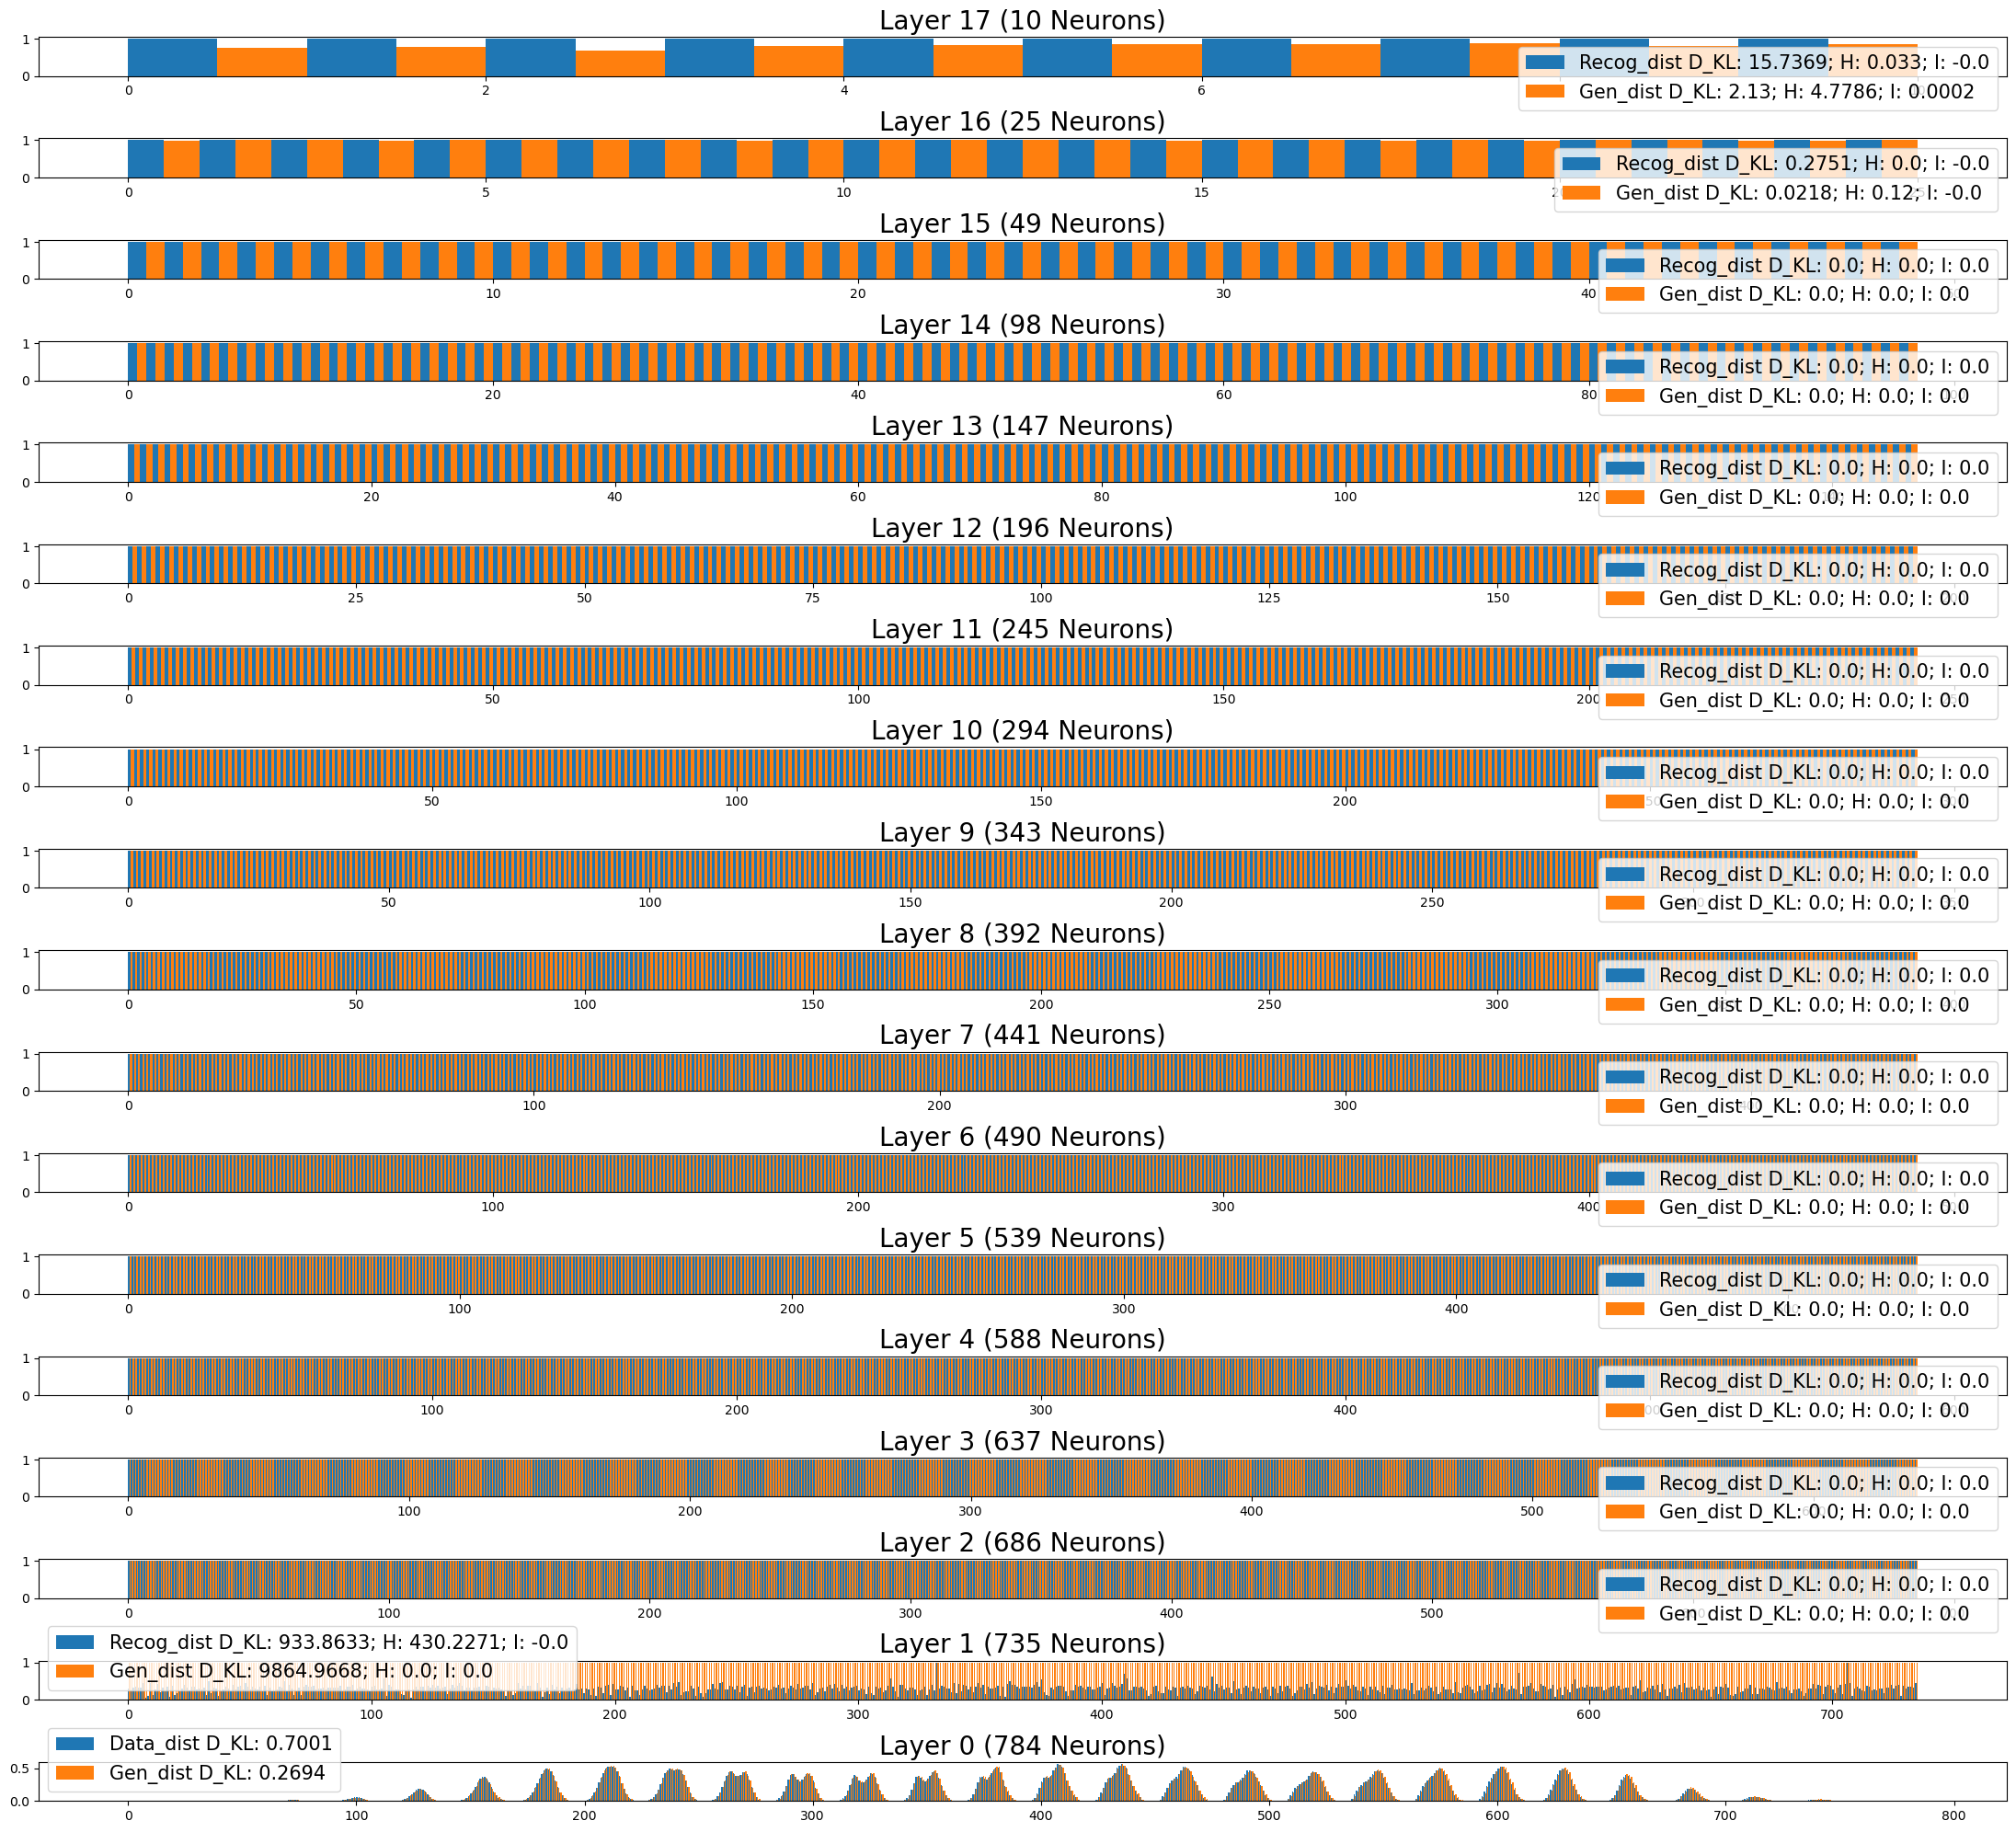

In [100]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 20))
H_Y_wake = H_Y_wake.to('cpu').numpy()
H_YX_wake = H_YX_wake.to('cpu').numpy()
I_wake = H_Y_wake - H_YX_wake
H_Y_sleep = H_Y_sleep.to('cpu').numpy()
H_YX_sleep = H_YX_sleep.to('cpu').numpy()
I_sleep = H_Y_sleep - H_YX_sleep

for i in range(n_layer-1):
    dist_w = Recog_sample['Layer_'+str(i)].float().mean(axis=1)
    dist_s = Gen_sample['Layer_'+str(i)].float().mean(axis=1)
    D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
    D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_wake[i-1],4)), "H(Y|X): "+str(np.around(H_YX_wake[i-1],4)),"I_XY: "+str(np.around(I_wake[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_sleep[i],4)), "H(Y|X): "+str(np.around(H_YX_sleep[i],4)),"I_XY: "+str(np.around(I_sleep[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_wake[i-1],4))+ "; I: "+ str(np.around(I_wake[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_sleep[i],4))+ "; I: "+ str(np.around(I_sleep[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[0,i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
plt.tight_layout(pad=1)    
plt.show()

In [106]:
Analytic_MNIST_new_batch5000_l1

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Phi_Loss_Layer_4,Phi_Loss_Layer_5,Phi_Loss_Layer_6,Phi_Loss_Layer_7,Phi_Loss_Layer_8,Phi_Loss_Layer_9,Theta_Loss_Layer_0,...,Gen_H_Layer_9,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3,Gen_I_Layer_4,Gen_I_Layer_5,Gen_I_Layer_6,Gen_I_Layer_7,Gen_I_Layer_8,Gen_I_Layer_9
0,9.558345,10.169810,9.090590,8.906387,8.833921,8.686323,8.069989,6.907906,4.777973,9.623112,...,15.295483,-0.000044,-0.000025,-0.000008,0.000002,0.000002,0.000027,0.000046,0.024082,0.007315
1,3.629129,4.440176,1.437043,1.023701,0.828956,0.652730,0.355488,0.297463,0.486563,2.621040,...,15.828798,-0.000027,-0.000069,-0.000065,-0.000010,3.450359,25.092987,16.947592,16.027895,9.972886
2,3.618255,4.411416,1.438795,1.021681,0.758461,0.349905,0.301407,0.269058,0.484462,2.625973,...,15.827031,-0.000011,-0.000025,-0.000019,20.175531,24.624422,28.662975,20.485199,16.514860,10.105296
3,3.610989,4.414405,1.453876,1.026857,0.573571,0.333507,0.287285,0.257698,0.484051,2.621571,...,15.825633,-0.000053,-0.000019,-0.000008,29.166340,31.549600,25.782652,20.315603,16.834938,10.145937
4,3.609618,4.432313,1.436259,1.036238,0.480320,0.262423,0.285037,0.253789,0.484142,2.630916,...,15.829835,-0.000042,-0.000042,-0.000038,30.309465,35.337982,28.000877,20.553560,17.084002,10.194837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1.783457,4.437513,1.449875,0.580226,0.128184,0.134780,0.263640,0.245474,0.483493,2.631906,...,15.827120,-0.000027,0.000002,132.892840,44.027782,33.372543,27.524666,22.241037,17.556429,10.250548
142,1.755560,4.437985,1.435508,0.578341,0.127031,0.135282,0.263247,0.245545,0.483008,2.632320,...,15.825682,-0.000004,-0.000044,127.825740,45.100628,33.432970,27.305492,22.112715,17.465765,10.252445
143,1.736384,4.437964,1.454785,0.590484,0.127592,0.134912,0.264319,0.245855,0.483787,2.638741,...,15.827483,0.000004,-0.000025,123.066950,44.448586,33.373795,27.356220,21.970690,17.434286,10.236175
144,1.750272,4.430208,1.424584,0.576949,0.126294,0.134696,0.263433,0.245814,0.482959,2.620090,...,15.821604,-0.000027,-0.000055,127.962660,44.673010,33.239620,27.292759,21.790789,17.347034,10.291680


In [46]:
gen_batch_size = 10
Gen_sample, H_Y_sleep, H_YX_sleep = sleep_sample(Theta,gen_batch_size,dev)
gen = Gen_sample["Layer_0"]
gen.shape

torch.Size([784, 10])

In [47]:
gen_batch_size = 10
Gen_sample = sleep_sample_HM(Theta_HM,gen_batch_size,dev)
gen = Gen_sample["Layer_0"]
gen.shape

torch.Size([784, 10])

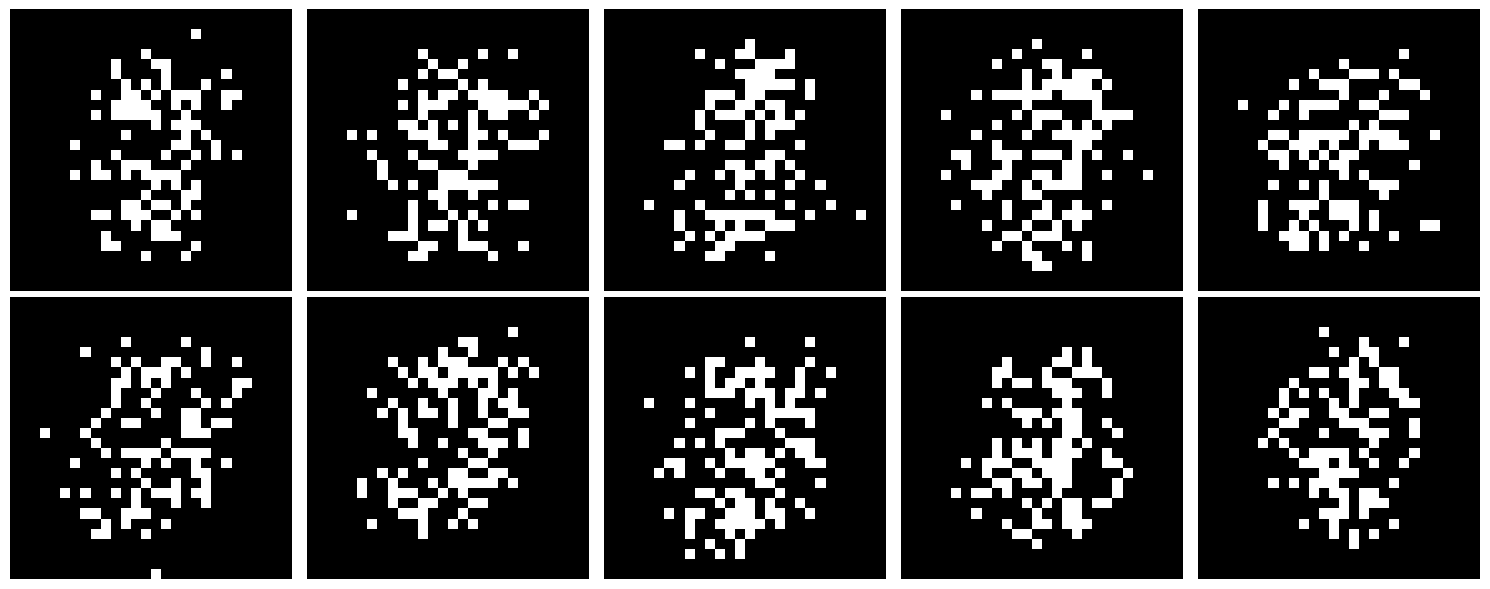

In [47]:
# Create a figure to display the images
fig, axs = plt.subplots(2, 5,figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

In [971]:
# Analytic_MHM_layer1.to_csv('Analytic_MHM_layer1.csv', index = False)

In [1255]:
# parameters = {'Phi': Phi, 'Theta': Theta}
# torch.save(parameters,'Parameters_MHM_layer2_fixed')

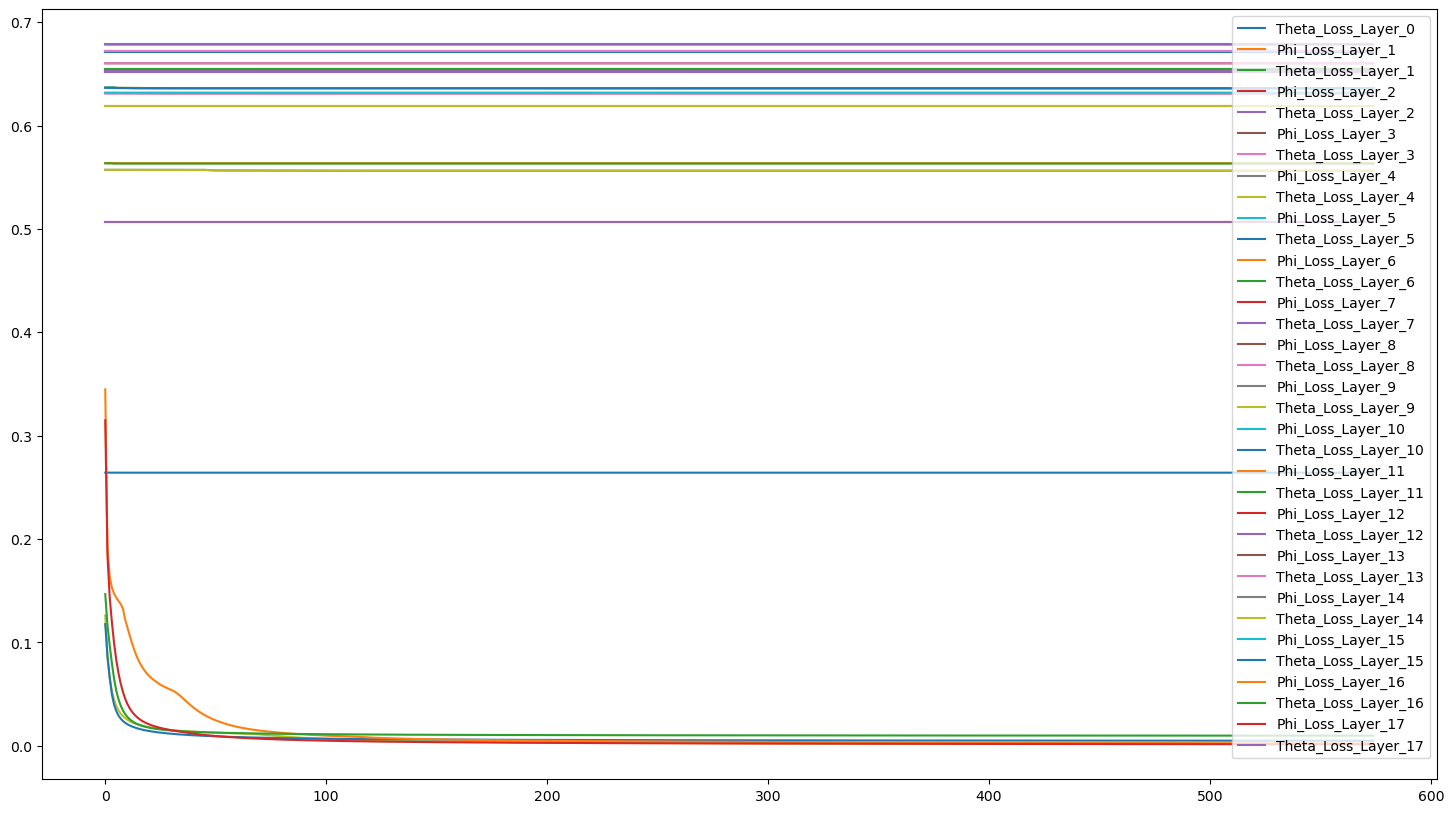

In [55]:
Analytic = Analytic_MNIST_11_19_wsMI_l1
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)])[1:],label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)])[1:],label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)])[1:],label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

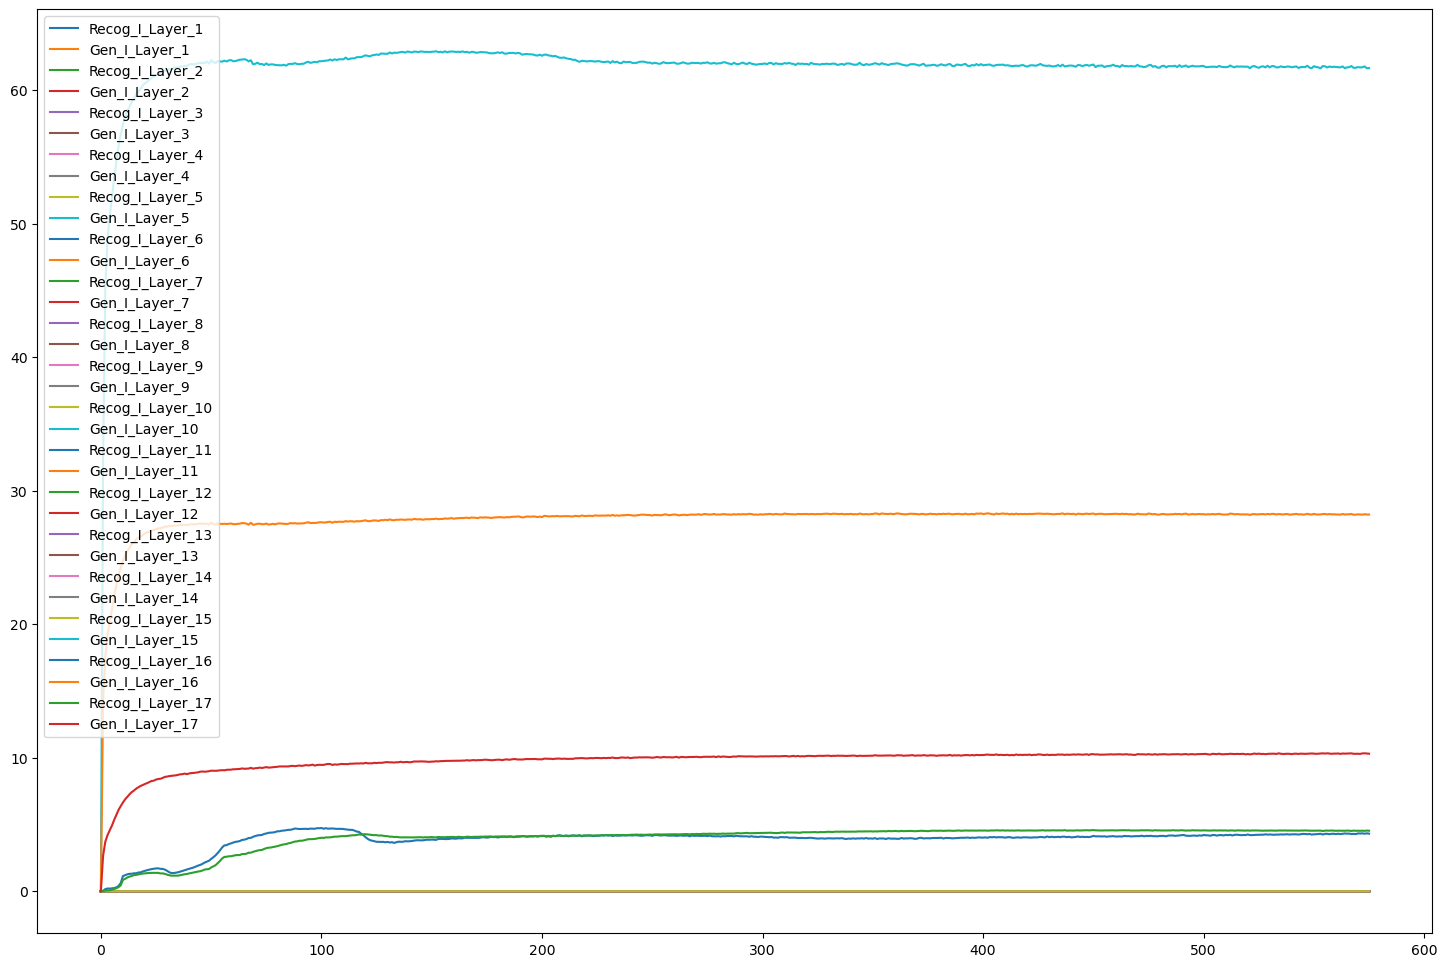

In [56]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

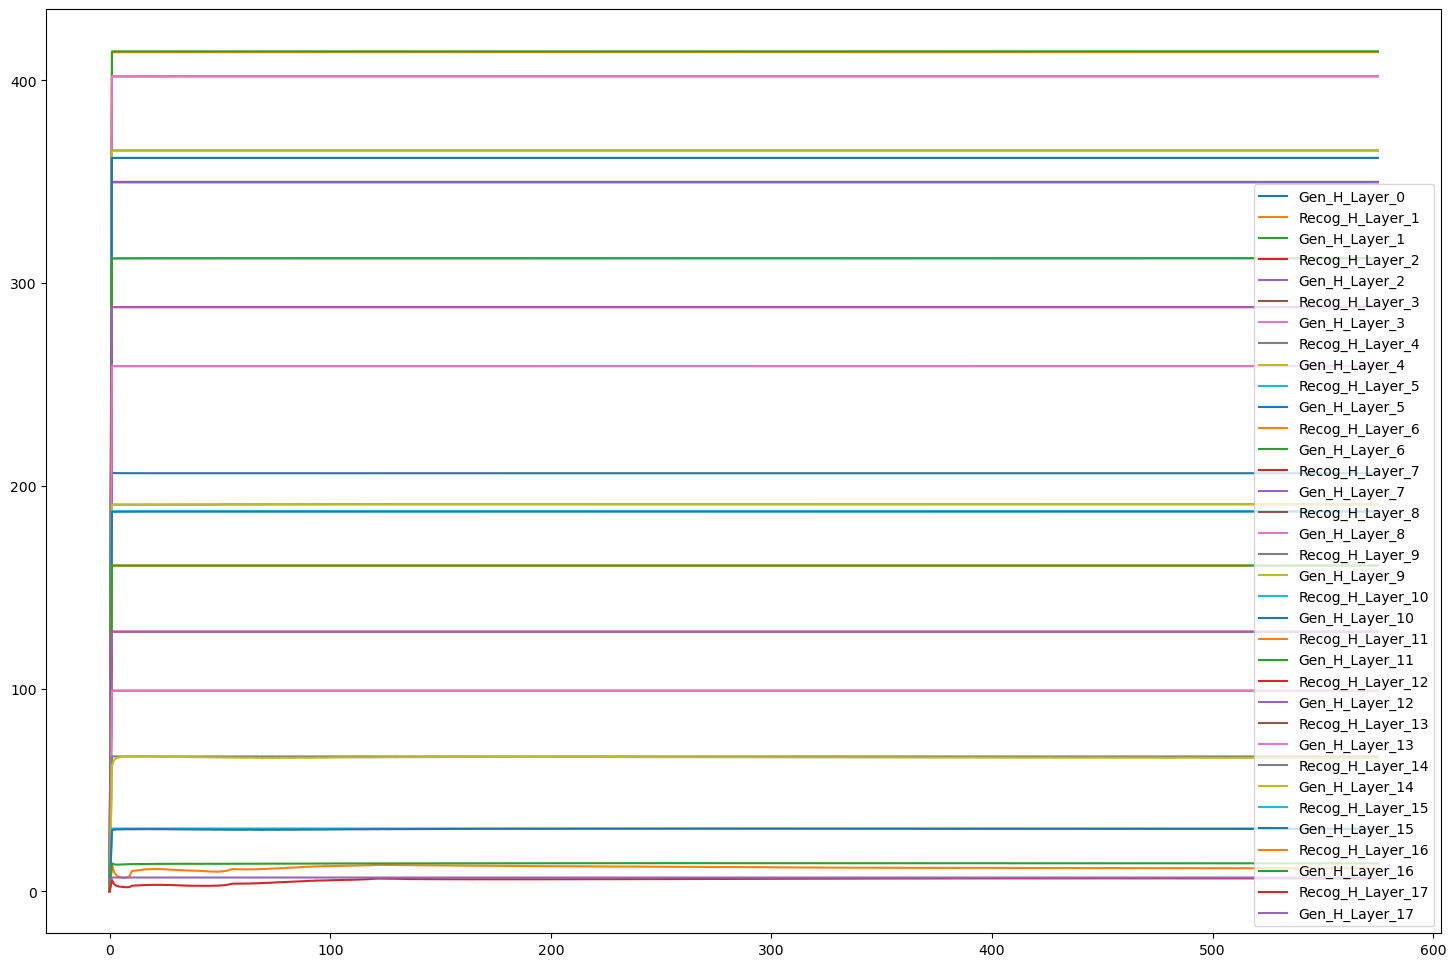

In [57]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [91]:
n_dz[:-1] * np.log(2)

tensor([[543.4274, 475.4990, 407.5706, 339.6421, 271.7137, 203.7853, 135.8568,
          67.9284,  33.9642,  17.3287,   0.6931]])